# पिटर र भेडिया: रिइन्फोर्समेन्ट लर्निङ प्राइमर

यस ट्युटोरियलमा, हामी रिइन्फोर्समेन्ट लर्निङलाई बाटो खोज्ने समस्यामा कसरी लागू गर्ने भन्ने कुरा सिक्नेछौं। यो सेटिङ रूसी संगीतकार [सेर्गेई प्रोकोफिएभ](https://en.wikipedia.org/wiki/Sergei_Prokofiev) द्वारा रचित [पिटर र भेडिया](https://en.wikipedia.org/wiki/Peter_and_the_Wolf) नामक संगीत परी कथा बाट प्रेरित छ। यो कथा युवा अग्रगामी पिटरको हो, जसले साहसिक रूपमा आफ्नो घरबाट बाहिर निस्केर जंगलको खुला ठाउँमा भेडियालाई पछ्याउन जान्छ। हामी मेसिन लर्निङ एल्गोरिदमलाई तालिम दिनेछौं जसले पिटरलाई वरपरको क्षेत्र अन्वेषण गर्न र एक उत्तम नेभिगेसन नक्सा बनाउन मद्दत गर्नेछ।

सुरुमा, केही उपयोगी पुस्तकालयहरू आयात गरौं:


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math

## पुनर्बलन शिक्षणको अवलोकन

**पुनर्बलन शिक्षण** (RL) एउटा शिक्षण प्रविधि हो जसले हामीलाई कुनै **पर्यावरण**मा **एजेन्ट**को उत्तम व्यवहार सिक्न धेरै प्रयोगहरू चलाएर अनुमति दिन्छ। यस पर्यावरणमा एजेन्टसँग केही **लक्ष्य** हुनुपर्छ, जुन **पुरस्कार कार्य**द्वारा परिभाषित गरिएको हुन्छ।

## पर्यावरण

सजिलोको लागि, हामी पिटरको संसारलाई `width` x `height` आकारको वर्गाकार बोर्ड मानौं। यस बोर्डको प्रत्येक कोषमा निम्नमध्ये कुनै एक हुन सक्छ:
* **जमिन**, जहाँ पिटर र अन्य प्राणीहरू हिँड्न सक्छन्
* **पानी**, जहाँ स्पष्ट रूपमा हिँड्न सकिँदैन
* **रुख** वा **घाँस** - आराम गर्न सकिने स्थान
* **स्याउ**, जुन पिटरले आफूलाई खानाको लागि पाउन खुसी हुने कुरा हो
* **भेँडिया**, जुन खतरनाक छ र टाढा रहनुपर्छ

पर्यावरणसँग काम गर्नको लागि, हामी `Board` नामको एउटा कक्षा परिभाषित गर्नेछौं। यस नोटबुकलाई धेरै जटिल नबनाउनको लागि, बोर्डसँग काम गर्नको लागि सबै कोडलाई छुट्टै `rlboard` मोड्युलमा सारिएको छ, जुन हामी अहिले आयात गर्नेछौं। तपाईं यस मोड्युलभित्र हेरेर कार्यान्वयनको आन्तरिक विवरणहरू बुझ्न सक्नुहुन्छ।


In [2]:
from rlboard import *

अब एउटा र्यान्डम बोर्ड बनाउँ र हेर्नुहोस् यो कस्तो देखिन्छ:


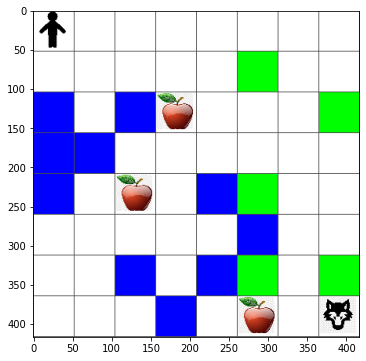

In [3]:
width, height = 8,8
m = Board(width,height)
m.randomize(seed=13)
m.plot()

## कार्यहरू र नीति

हाम्रो उदाहरणमा, पिटरको लक्ष्य एउटा स्याउ फेला पार्नु हो, भेडिया र अन्य अवरोधहरूबाट जोगिँदै। यसका लागि, ऊ स्याउ भेट्टाएसम्म वरपर हिँड्न सक्छ। त्यसैले, कुनै पनि स्थानमा ऊ तलका कार्यहरू मध्ये एक छान्न सक्छ: माथि, तल, बायाँ र दायाँ। हामी ती कार्यहरूलाई एउटा शब्दकोशको रूपमा परिभाषित गर्नेछौं, र तिनीहरूलाई सम्बन्धित समन्वय परिवर्तनहरूको जोडीहरूसँग नक्सा गर्नेछौं। उदाहरणका लागि, दायाँतर्फ सर्ने (`R`) ले `(1,0)` जोडीसँग मेल खानेछ।


In [4]:
actions = { "U" : (0,-1), "D" : (0,1), "L" : (-1,0), "R" : (1,0) }
action_idx = { a : i for i,a in enumerate(actions.keys()) }

हाम्रो एजेन्ट (Peter) को रणनीति एक प्रकारको **नीति** द्वारा परिभाषित गरिएको छ। अब सबैभन्दा सरल नीति **र्यान्डम वाक** भनिने नीति विचार गरौं।

## र्यान्डम वाक

पहिला हाम्रो समस्या समाधान गर्न र्यान्डम वाक रणनीति कार्यान्वयन गरेर सुरु गरौं।


In [5]:
def random_policy(m):
    return random.choice(list(actions))

def walk(m,policy,start_position=None):
    n = 0 # number of steps
    # set initial position
    if start_position:
        m.human = start_position 
    else:
        m.random_start()
    while True:
        if m.at() == Board.Cell.apple:
            return n # success!
        if m.at() in [Board.Cell.wolf, Board.Cell.water]:
            return -1 # eaten by wolf or drowned
        while True:
            a = actions[policy(m)]
            new_pos = m.move_pos(m.human,a)
            if m.is_valid(new_pos) and m.at(new_pos)!=Board.Cell.water:
                m.move(a) # do the actual move
                break
        n+=1

walk(m,random_policy)

18

हामीले र्यान्डम वाक प्रयोग धेरै पटक चलाएर लिएका औसत कदमहरूको संख्या हेर्नुहोस्:


In [6]:
def print_statistics(policy):
    s,w,n = 0,0,0
    for _ in range(100):
        z = walk(m,policy)
        if z<0:
            w+=1
        else:
            s += z
            n += 1
    print(f"Average path length = {s/n}, eaten by wolf: {w} times")

print_statistics(random_policy)

Average path length = 32.87096774193548, eaten by wolf: 7 times


## पुरस्कार कार्य

हाम्रो नीति अझ बौद्धिक बनाउनका लागि, कुन चालहरू अरूभन्दा "राम्रो" छन् भन्ने बुझ्न आवश्यक छ।


In [7]:
move_reward = -0.1
goal_reward = 10
end_reward = -10

def reward(m,pos=None):
    pos = pos or m.human
    if not m.is_valid(pos):
        return end_reward
    x = m.at(pos)
    if x==Board.Cell.water or x == Board.Cell.wolf:
        return end_reward
    if x==Board.Cell.apple:
        return goal_reward
    return move_reward

## क्यू-लर्निङ

क्यू-टेबल, वा बहु-आयामिक एरे निर्माण गर्नुहोस्। किनकि हाम्रो बोर्डको आयाम `width` x `height` छ, हामी क्यू-टेबललाई `width` x `height` x `len(actions)` आकारको numpy एरेद्वारा प्रतिनिधित्व गर्न सक्छौं:


In [8]:
Q = np.ones((width,height,len(actions)),dtype=np.float)*1.0/len(actions)

Q-Table लाई बोर्डमा तालिका देखाउनको लागि plot function मा पास गर्नुहोस्:


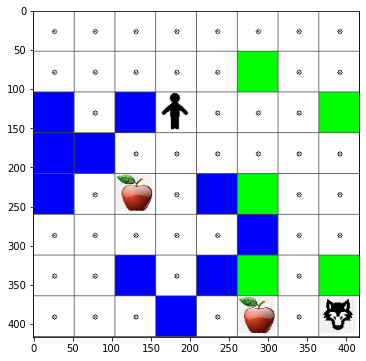

In [9]:
m.plot(Q)

## Q-Learning को सार: बेलम्यान समीकरण र सिकाइ एल्गोरिदम

हाम्रो सिकाइ एल्गोरिदमको लागि एउटा छद्म-कोड लेख्नुहोस्:

* सबै अवस्थाहरू र क्रियाहरूको लागि समान संख्याहरूको साथ Q-तालिका Q आरम्भ गर्नुहोस्
* सिकाइ दर $\alpha\leftarrow 1$ सेट गर्नुहोस्
* धेरै पटक सिमुलेशन दोहोर्याउनुहोस्
   1. कुनै पनि अनियमित स्थानबाट सुरु गर्नुहोस्
   1. दोहोर्याउनुहोस्
        1. अवस्थामा $s$ मा एउटा क्रिया $a$ चयन गर्नुहोस्
        2. नयाँ अवस्था $s'$ मा सर्ने क्रिया कार्यान्वयन गर्नुहोस्
        3. यदि खेलको अन्त्य अवस्था भेटिन्छ, वा कुल पुरस्कार धेरै सानो छ भने - सिमुलेशनबाट बाहिर निस्कनुहोस्  
        4. नयाँ अवस्थामा पुरस्कार $r$ गणना गर्नुहोस्
        5. बेलम्यान समीकरण अनुसार Q-फंक्शन अद्यावधिक गर्नुहोस्: $Q(s,a)\leftarrow (1-\alpha)Q(s,a)+\alpha(r+\gamma\max_{a'}Q(s',a'))$
        6. $s\leftarrow s'$ गर्नुहोस्
        7. कुल पुरस्कार अद्यावधिक गर्नुहोस् र $\alpha$ घटाउनुहोस्।

## उपयोग बनाम अन्वेषण

सर्वश्रेष्ठ दृष्टिकोण भनेको अन्वेषण र उपयोगको बीच सन्तुलन कायम गर्नु हो। जब हामी हाम्रो वातावरणको बारेमा बढी सिक्छौं, हामी इष्टतम मार्ग पछ्याउन बढी सम्भावना हुन्छौं, तर कहिलेकाहीँ अन्वेषण नगरिएको बाटो चयन गर्नु पनि महत्त्वपूर्ण हुन्छ।

## पाइथन कार्यान्वयन

अब हामी सिकाइ एल्गोरिदम कार्यान्वयन गर्न तयार छौं। त्यसअघि, हामीलाई एउटा यस्तो फंक्शन चाहिन्छ जसले Q-तालिकामा भएका कुनै पनि संख्याहरूलाई सम्बन्धित क्रियाहरूको लागि सम्भावनाहरूको भेक्टरमा रूपान्तरण गर्नेछ:


In [10]:
def probs(v,eps=1e-4):
    v = v-v.min()+eps
    v = v/v.sum()
    return v

हामी मूल भेक्टरमा `eps` को सानो मात्रा थप्छौं ताकि सुरुवाती अवस्थामा, जब भेक्टरका सबै घटकहरू समान हुन्छन्, शून्यद्वारा भाग गर्ने समस्या नआओस्।

वास्तविक सिकाइ एल्गोरिदम, जसलाई हामी ५००० प्रयोगहरूका लागि चलाउनेछौं, जसलाई **epochs** पनि भनिन्छ:


In [11]:

from IPython.display import clear_output

lpath = []

for epoch in range(10000):
    clear_output(wait=True)
    print(f"Epoch = {epoch}",end='')

    # Pick initial point
    m.random_start()
    
    # Start travelling
    n=0
    cum_reward = 0
    while True:
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        dpos = actions[a]
        m.move(dpos,check_correctness=False) # we allow player to move outside the board, which terminates episode
        r = reward(m)
        cum_reward += r
        if r==end_reward or cum_reward < -1000:
            print(f" {n} steps",end='\r')
            lpath.append(n)
            break
        alpha = np.exp(-n / 3000)
        gamma = 0.5
        ai = action_idx[a]
        Q[x,y,ai] = (1 - alpha) * Q[x,y,ai] + alpha * (r + gamma * Q[x+dpos[0], y+dpos[1]].max())
        n+=1

यस एल्गोरिथ्मलाई कार्यान्वयन गरेपछि, Q-तालिका विभिन्न चरणहरूमा विभिन्न कार्यहरूको आकर्षणलाई परिभाषित गर्ने मानहरूद्वारा अद्यावधिक गरिएको हुनुपर्छ। तालिकालाई यहाँ दृश्यात्मक बनाउनुहोस्:


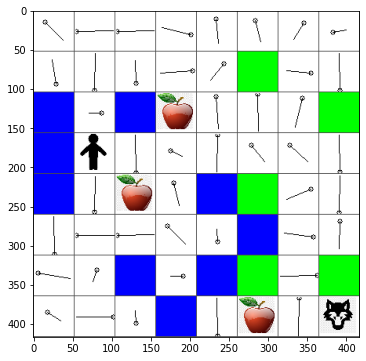

In [12]:
m.plot(Q)

## नीति जाँच गर्दै

किनभने Q-Table ले प्रत्येक अवस्थामा प्रत्येक क्रियाको "आकर्षण" सूचीबद्ध गर्दछ, यसलाई हाम्रो संसारमा प्रभावकारी नेभिगेसन परिभाषित गर्न प्रयोग गर्नु धेरै सजिलो छ। सबैभन्दा साधारण अवस्थामा, हामी केवल Q-Table मा सबैभन्दा उच्च मानसँग मेल खाने क्रिया चयन गर्न सक्छौं:


In [13]:
def qpolicy_strict(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = list(actions)[np.argmax(v)]
        return a

walk(m,qpolicy_strict)

2

यदि तपाईंले माथिको कोड धेरै पटक प्रयास गर्नुभयो भने, तपाईंले देख्न सक्नुहुन्छ कि कहिलेकाहीं यो "अड्किन्छ", र तपाईंले यसलाई रोक्नको लागि नोटबुकमा STOP बटन थिच्न आवश्यक पर्छ।

> **कार्य १:** `walk` फङ्सनलाई संशोधन गरेर पथको अधिकतम लम्बाइ निश्चित संख्यामा चरणहरू (जस्तै, १००) द्वारा सीमित गर्नुहोस्, र माथिको कोडले समय-समयमा यो मान फिर्ता गरेको हेर्नुहोस्।

> **कार्य २:** `walk` फङ्सनलाई संशोधन गरेर यसले पहिले नै गएको स्थानहरूमा पुन: नजाने सुनिश्चित गर्नुहोस्। यसले `walk` लाई लुपिङ हुनबाट रोक्नेछ, तर एजेन्ट अझै पनि यस्तो स्थानमा "फस्न" सक्दछ जहाँबाट यो बाहिर निस्कन असमर्थ हुन्छ।


In [14]:

def qpolicy(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        return a

print_statistics(qpolicy)

Average path length = 3.45, eaten by wolf: 0 times


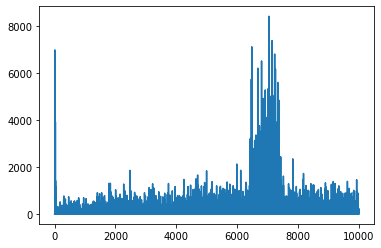

In [15]:
plt.plot(lpath)

के हामीले यहाँ देख्छौं भने सुरुमा औसत पथको लम्बाइ बढेको छ। यसको कारण सम्भवतः यो हो कि जब हामी वातावरणको बारेमा केही थाहा पाउँदैनौं - हामी खराब अवस्थाहरू, पानी वा भेडिया जस्ता समस्यामा फस्न सक्छौं। जब हामी थप सिक्छौं र यो ज्ञान प्रयोग गर्न थाल्छौं, हामी वातावरणलाई लामो समयसम्म अन्वेषण गर्न सक्छौं, तर अझै पनि स्याउहरू कहाँ छन् भन्ने राम्रोसँग थाहा छैन।

जब हामी पर्याप्त सिक्छौं, एजेन्टलाई लक्ष्य प्राप्त गर्न सजिलो हुन्छ, र पथको लम्बाइ घट्न थाल्छ। तर, हामी अझै अन्वेषण गर्न खुला छौं, त्यसैले हामी प्रायः उत्तम पथबाट टाढा जान्छौं र नयाँ विकल्पहरू अन्वेषण गर्छौं, जसले पथलाई आदर्शभन्दा लामो बनाउँछ।

यस ग्राफमा हामीले अर्को कुरा पनि देख्छौं कि कुनै बिन्दुमा लम्बाइ अचानक बढेको छ। यसले प्रक्रियाको स्टोकेस्टिक प्रकृति देखाउँछ, र हामी कुनै बिन्दुमा Q-Table का गुणांकहरू "बिगार्न" सक्छौं, नयाँ मानहरूद्वारा तिनीहरूलाई ओभरराइट गरेर। यो आदर्श रूपमा सिकाइ दर घटाएर न्यूनतम गर्नुपर्छ (जस्तै, प्रशिक्षणको अन्त्यतिर हामी Q-Table का मानहरूलाई सानो मानद्वारा मात्र समायोजन गर्छौं)।

समग्रमा, यो सम्झनु महत्त्वपूर्ण छ कि सिकाइ प्रक्रियाको सफलता र गुणस्तर धेरै हदसम्म विभिन्न प्यारामिटरहरूमा निर्भर गर्दछ, जस्तै सिकाइ दर, सिकाइ दरको कमी, र डिस्काउन्ट फ्याक्टर। यीलाई प्रायः **हाइपरप्यारामिटरहरू** भनिन्छ, जसले प्रशिक्षणको क्रममा अनुकूलन गरिने **प्यारामिटरहरू** (जस्तै, Q-Table का गुणांकहरू) बाट छुट्याउँछ। उत्तम हाइपरप्यारामिटर मानहरू पत्ता लगाउने प्रक्रियालाई **हाइपरप्यारामिटर अनुकूलन** भनिन्छ, र यसले छुट्टै विषयको योग्य छ।


## अभ्यास
#### पिटर र ब्वाँसोको संसारलाई अझ यथार्थपरक बनाउने

हाम्रो अवस्थामा, पिटर लगभग थाक्न वा भोकाउन नपरी सजिलै हिँडडुल गर्न सक्थ्यो। तर, यथार्थपरक संसारमा, उसले समय-समयमा बस्न र आराम गर्नुपर्ने हुन्छ, साथै आफूलाई खाना खुवाउनुपर्ने हुन्छ। हाम्रो संसारलाई अझ यथार्थपरक बनाउन निम्न नियमहरू लागू गरौं:

1. एउटा स्थानबाट अर्को स्थानमा जाँदा, पिटरले **ऊर्जा** गुमाउँछ र केही **थकान** बढाउँछ।
2. पिटरले स्याउ खाएर थप ऊर्जा प्राप्त गर्न सक्छ।
3. पिटरले रूखमुनि वा घाँसमा आराम गरेर (अर्थात्, रूख वा घाँस भएको स्थानमा हिँडेर - हरियो क्षेत्र) थकान हटाउन सक्छ।
4. पिटरले ब्वाँसो फेला पार्न र मार्नुपर्ने हुन्छ।
5. ब्वाँसो मार्नका लागि, पिटरसँग निश्चित स्तरको ऊर्जा र थकान हुनुपर्छ, अन्यथा ऊ लडाइँमा हार्छ।

खेलका नियमहरू अनुसार माथिको reward function परिमार्जन गर्नुहोस्, reinforcement learning algorithm चलाएर खेल जित्नको लागि सबैभन्दा राम्रो रणनीति सिक्नुहोस्, र random walk को नतिजालाई तपाईंको algorithm सँग तुलना गर्नुहोस्, खेल जित्ने र हार्ने संख्याको आधारमा।

> **Note**: यसलाई काम गर्नका लागि तपाईंले hyperparameters समायोजन गर्नुपर्ने हुन सक्छ, विशेष गरी epochs को संख्या। किनभने खेलको सफलता (ब्वाँसोसँगको लडाइँ) दुर्लभ घटना हो, तपाईंले धेरै लामो training समयको अपेक्षा गर्न सक्नुहुन्छ।



---

**अस्वीकरण**:  
यो दस्तावेज़ AI अनुवाद सेवा [Co-op Translator](https://github.com/Azure/co-op-translator) प्रयोग गरेर अनुवाद गरिएको छ। हामी शुद्धताको लागि प्रयास गर्छौं, तर कृपया ध्यान दिनुहोस् कि स्वचालित अनुवादहरूमा त्रुटि वा अशुद्धता हुन सक्छ। यसको मूल भाषामा रहेको मूल दस्तावेज़लाई आधिकारिक स्रोत मानिनुपर्छ। महत्वपूर्ण जानकारीको लागि, व्यावसायिक मानव अनुवाद सिफारिस गरिन्छ। यस अनुवादको प्रयोगबाट उत्पन्न हुने कुनै पनि गलतफहमी वा गलत व्याख्याको लागि हामी जिम्मेवार हुने छैनौं।
